# Zavr≈°ni projektni zadatak: Analiza podataka za smanjenje ugljiƒçnog otiska Republike 
Cilj ovog zadatka je istra≈æiti potencijal smanjenja ugljiƒçnog otiska Republike Hrvatske optimiziranjem lokacija za postavljanje solarnih i vjetroelektrana na temelju dostupnih podataka o klimi.

Svrha zadatka je pokazati kako analizom podataka o klimatskim uvjetima (vjetrovi i osunƒçanost) mo≈æemo identificirati optimalne lokacije za obnovljive izvore energije i tako doprinijeti smanjenju emisija ugljiƒçnog dioksida.

Autor: **Maksim Kos**

## Zadatak

1. **Prikupljanje podataka:**
    - Pronaƒëite i preuzmite dostupne podatke o klimatskim uvjetima za Hrvatsku, fokusirajuƒái se na vjetrove i osunƒçanost. Primjeri izvora podataka su:
        - [Podaci o klimi na meteo.hr](https://meteo.hr)
        - [Opis klime u Hrvatskoj na meteo.hr](https://meteo.hr)
        - PDF dokument na klima.hr
    - Pronaƒëite podatke o emisijama ugljiƒçnog dioksida za Republiku Hrvatsku kako biste mogli procijeniti utjecaj obnovljivih izvora energije.

2. **Izrada baze podataka:**
    - Kreirajte bazu podataka (SQLite) koja ƒáe sadr≈æavati dvije tablice:
        - **klima**: podaci o vjetrovima i osunƒçanosti (lokacija, brzina vjetra, broj sunƒçanih sati, itd.).
        - **ugljik**: podaci o emisijama ugljiƒçnog dioksida (godina, ukupna emisija, sektor).
    - Svaka tablica treba biti jasno definirana i sadr≈æavati relevantne informacije.

3. **Analiza i integracija podataka:**
    - Implementirajte obradu podataka kako biste na temelju dostupnih informacija identificirali optimalne lokacije za postavljanje solarnih i vjetroelektrana.
    - Procijenite koliko bi se emisije ugljika smanjile ako bi se elektrane postavile na sve identificirane lokacije.

4. **Vizualizacija:**
    - Vizualizirajte klimatske podatke i lokacije elektrana pomoƒáu modula GeoPandas ili sliƒçnog alata.
    - Vizualizacije trebaju ukljuƒçivati:
        - Lokacije s najboljim potencijalom za solarne i vjetroelektrane.
        - Klimatske uvjete (npr. vjetrovne karte, mape osunƒçanosti).
    - Osigurajte da vizualizacija bude interaktivna ili lako razumljiva.

5. **Zakljuƒçak:**
    - Baza podataka s prikupljenim i obraƒëenim podacima.
    - Jupyter Notebook radna bilje≈ænica s dokumentacijom svih koraka obrade i analize podataka.
    - Vizualizacija podataka i konaƒçni zakljuƒçci temeljeni na analizi.


## **NAPOMENA**
Preporuƒçuje se kori≈°tenje modula poput pandas, matplotlib, GeoPandas, ili drugih relevantnih alata za analizu i vizualizaciju podataka. Prilikom preuzimanja podataka s mre≈ænih stranica mo≈æete koristiti alate poput `requests` i `BeautifulSoup` za automatizaciju.

Predajte projekt u obliku Jupyter Notebooka, ukljuƒçujuƒái dokumentaciju svih dijelova koda te zakljuƒçke temeljem analize. Poka≈æite kako analizom podataka mo≈æemo donijeti informirane odluke za bolju buduƒánost!

In [118]:
# Biblioteke
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3 as db
import numpy as np
import folium
from shapely.geometry import shape
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
import time
import json


---

### 1. Prikupljanje podataka

#### Prikupljanje podataka o emisijama ugljuƒçnog dioksida
- Izvor: https://www.worldometers.info/co2-emissions/croatia-co2-emissions/

In [119]:
# Postavke za headless browser
options = Options()
options.add_argument("--headless")
driver = webdriver.Chrome(options=options)

# Otvaranje stranice
url = "https://www.worldometers.info/co2-emissions/croatia-co2-emissions/"
driver.get(url)

# ƒåekanje uƒçitavanja JS-a
time.sleep(3)

# Preuzimanje HTML-a nakon ≈°to se stranica uƒçita
soup = BeautifulSoup(driver.page_source, 'html.parser')
driver.quit()  

# Tra≈æenje tablice
table = soup.find('table')

# Prikupljanje naziva stupaca
stupci = [th.text.strip() for th in table.find('thead').find_all('th')]

# Redovi
data = []
for red in table.find('tbody').find_all('tr'):
    cells = red.find_all('td')
    if len(cells) > 1:
        data.append([cell.text.strip() for cell in cells])

# Novi DataFrame
df_emisije_co2 = pd.DataFrame(data, columns=stupci)

# Ispis
print(df_emisije_co2.head())

   Year Fossil CO2emissions(tons) CO2 emissionschange CO2 emissionsper capita  \
0  2022                17,224,970               1.22%                    4.41   
1  2021                17,017,660               0.02%                    4.34   
2  2020                17,013,970              ‚àí5.14%                     4.3   
3  2019                17,935,050               1.29%                     4.5   
4  2018                17,707,470              ‚àí5.48%                     4.4   

  Population Pop.change Share of World'sCO2 emissions  
0  3,907,027     ‚àí0.45%                        0.045%  
1  3,924,610     ‚àí0.74%                        0.045%  
2  3,953,958     ‚àí0.81%                        0.047%  
3  3,986,334     ‚àí0.96%                        0.047%  
4  4,024,868     ‚àí1.33%                        0.047%  


In [120]:
# Ispis stupca iz df_emisije_co2
print(df_emisije_co2.columns)

Index(['Year', 'Fossil CO2emissions(tons)', 'CO2 emissionschange',
       'CO2 emissionsper capita', 'Population', 'Pop.change',
       'Share of World'sCO2 emissions'],
      dtype='object')


In [121]:
# Prevaƒëanje na Hrvatski
df_emisije_co2.rename(columns={"Year": "Godina",
                               "Fossil CO2emissions(tons)": "Emisije fosilnog CO2 (tone)",
                               "CO2 emissionschange": "Promjena emisije CO2 (%)",
                               "CO2 emissionsper capita": "Emisije CO2 po glavi stanovnika",
                               "Population": "Stanovni≈°tvo",
                               "Pop.change": "Promjena stanovni≈°tva (%)",
                               "Share of World'sCO2 emissions": "Udio u svjetskim emisijama CO2 (%)"}, inplace=True)
df_emisije_co2.head()
# Ovdje je stavljen argument inplace=True zato jer radim izmjenu na postojeƒáem DataFrame-u (ne vraƒáam novi objekt); U sliƒçaju da sam stavio Fale, funkcija rename bi vratila novi DataFrame s promjenama

Godina Emisije fosilnog CO2 (tone) Promjena emisije CO2 (%)  \
0   2022                  17,224,970                    1.22%   
1   2021                  17,017,660                    0.02%   
2   2020                  17,013,970                   ‚àí5.14%   
3   2019                  17,935,050                    1.29%   
4   2018                  17,707,470                   ‚àí5.48%   

  Emisije CO2 po glavi stanovnika Stanovni≈°tvo Promjena stanovni≈°tva (%)  \
0                            4.41    3,907,027                    ‚àí0.45%   
1                            4.34    3,924,610                    ‚àí0.74%   
2                             4.3    3,953,958                    ‚àí0.81%   
3                             4.5    3,986,334                    ‚àí0.96%   
4                             4.4    4,024,868                    ‚àí1.33%   

  Udio u svjetskim emisijama CO2 (%)  
0                             0.045%  
1                             0.045%  
2                             0.047%  
3                             0.047%  
4                             0.047%

In [122]:
df_emisije_co2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 7 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   Godina                              46 non-null     object
 1   Emisije fosilnog CO2 (tone)         46 non-null     object
 2   Promjena emisije CO2 (%)            46 non-null     object
 3   Emisije CO2 po glavi stanovnika     46 non-null     object
 4   Stanovni≈°tvo                        46 non-null     object
 5   Promjena stanovni≈°tva (%)           46 non-null     object
 6   Udio u svjetskim emisijama CO2 (%)  46 non-null     object
dtypes: object(7)
memory usage: 2.6+ KB


In [123]:
df_emisije_co2.head(5)

Godina Emisije fosilnog CO2 (tone) Promjena emisije CO2 (%)  \
0   2022                  17,224,970                    1.22%   
1   2021                  17,017,660                    0.02%   
2   2020                  17,013,970                   ‚àí5.14%   
3   2019                  17,935,050                    1.29%   
4   2018                  17,707,470                   ‚àí5.48%   

  Emisije CO2 po glavi stanovnika Stanovni≈°tvo Promjena stanovni≈°tva (%)  \
0                            4.41    3,907,027                    ‚àí0.45%   
1                            4.34    3,924,610                    ‚àí0.74%   
2                             4.3    3,953,958                    ‚àí0.81%   
3                             4.5    3,986,334                    ‚àí0.96%   
4                             4.4    4,024,868                    ‚àí1.33%   

  Udio u svjetskim emisijama CO2 (%)  
0                             0.045%  
1                             0.045%  
2                             0.047%  
3                             0.047%  
4                             0.047%

Zapisi u DataFrame-u su objekti, treba ih pretvoriti u brojeve kako bi se moglo raditi sa njima. Potrebno je ukloniti sve znakove ( , i %) pa zatim pretvoriti u numeriƒçke varijable. Stupce koji predstavljaju postotak treba podijeliti sa 100 ( 5% -> 0.05)

In [124]:
df_emisije_co2['Emisije fosilnog CO2 (tone)'] = (
    df_emisije_co2['Emisije fosilnog CO2 (tone)']
    .astype(str)
    .str.replace(',', '')
    .astype('int64')
)

df_emisije_co2['Promjena emisije CO2 (%)'] = (
    df_emisije_co2['Promjena emisije CO2 (%)']
    .astype(str)
    .str.replace('%', '')
    .str.replace('‚Äì', '-')  
    .str.replace('‚àí', '-')   
    .str.strip()
    .astype('float64') / 100
)

df_emisije_co2['Emisije CO2 po glavi stanovnika'] = (
    df_emisije_co2['Emisije CO2 po glavi stanovnika']
    .astype('float64')
)

df_emisije_co2['Stanovni≈°tvo'] = (
    df_emisije_co2['Stanovni≈°tvo']
    .astype(str)
    .str.replace(',', '')
    .astype('int64')
)

df_emisije_co2['Promjena stanovni≈°tva (%)'] = (
    df_emisije_co2['Promjena stanovni≈°tva (%)']
    .astype(str)
    .str.replace('%', '')
    .str.replace('‚Äì', '-') 
    .str.replace('‚àí', '-') 
    .str.strip()
    .astype('float64') / 100
)

df_emisije_co2['Udio u svjetskim emisijama CO2 (%)'] = (
    df_emisije_co2['Udio u svjetskim emisijama CO2 (%)']
    .astype(str)
    .str.replace('%', '')
    .str.strip()
    .astype('float64') / 100
)
df_emisije_co2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 7 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Godina                              46 non-null     object 
 1   Emisije fosilnog CO2 (tone)         46 non-null     int64  
 2   Promjena emisije CO2 (%)            46 non-null     float64
 3   Emisije CO2 po glavi stanovnika     46 non-null     float64
 4   Stanovni≈°tvo                        46 non-null     int64  
 5   Promjena stanovni≈°tva (%)           46 non-null     float64
 6   Udio u svjetskim emisijama CO2 (%)  46 non-null     float64
dtypes: float64(4), int64(2), object(1)
memory usage: 2.6+ KB


In [125]:
df_emisije_co2.head()

Godina  Emisije fosilnog CO2 (tone)  Promjena emisije CO2 (%)  \
0   2022                     17224970                    0.0122   
1   2021                     17017660                    0.0002   
2   2020                     17013970                   -0.0514   
3   2019                     17935050                    0.0129   
4   2018                     17707470                   -0.0548   

   Emisije CO2 po glavi stanovnika  Stanovni≈°tvo  Promjena stanovni≈°tva (%)  \
0                             4.41       3907027                    -0.0045   
1                             4.34       3924610                    -0.0074   
2                             4.30       3953958                    -0.0081   
3                             4.50       3986334                    -0.0096   
4                             4.40       4024868                    -0.0133   

   Udio u svjetskim emisijama CO2 (%)  
0                             0.00045  
1                             0.00045  
2                             0.00047  
3                             0.00047  
4                             0.00047

Sada kada je tablica prevedena i zapisi u njoj su numeriƒçkog tipa, mo≈æe se sa njom raditi!

#### Prikupljanje podataka o emisijama ugljuƒçnog dioksida po sektorima za svaku godinu (tone)
- Izvor podataka: https://www.worldometers.info/co2-emissions/croatia-co2-emissions/

Podaci na stranici su interaktivni, tj. za izradu grafikona kori≈°ten je JavaScript, te nije bilo moguƒáe napraviti WebScraping. Stoga mi je ovdje pomogao ChatGPT.<br>
Salo sam mu slike, te na temlju njih, on je podatke sa tih slika pretvarao u rijeƒçnike koji ƒáe biti kori≈°teni za izradu DataFrame-a.
- *"Jel ti mogu slati slike grafikona za pojedine godine, a ti ih pretvaraj u rijeƒçnike, koje ƒáu koristiti da kreiram DataFrame"* - **JA**
<br><br>
- *"Naravno! Mo≈æe≈° mi slati slike grafikona za pojedine godine, a ja ƒáu ih pretvarati u rjeƒçnike koje mo≈æe≈° koristiti za kreiranje DataFramea. Samo ih po≈°alji, pa ƒáemo krenuti!"* - **ChatGPT**

In [126]:
data_2006 = {
    "Godina": 2006,
    "Energetika": 5969430,
    "Poljoprivreda": 97640,
    "Industrijsko sagorijevanje": 3659360,
    "Transport": 6214300,
    "Zgrade": 3317600,
    "Eksploatacija goriva": 2059910,
    "Otpad": 430,
    "Procesi": 3089810
}

data_2007 = {
    "Godina": 2007,
    "Energetika": 5373390,
    "Poljoprivreda": 99000,
    "Industrijsko sagorijevanje": 3688280,
    "Transport": 6144560,
    "Zgrade": 3409240,
    "Eksploatacija goriva": 1550760,
    "Otpad": 440,
    "Procesi": 2956960
}

data_2008 = {
    "Godina": 2008,
    "Energetika": 4564120,
    "Poljoprivreda": 61440,
    "Industrijsko sagorijevanje": 3000720,
    "Transport": 6112640,
    "Zgrade": 3447570,
    "Eksploatacija goriva": 1940100,
    "Otpad": 110,
    "Procesi": 2445340
}

data_2009 = {
    "Godina": 2009,
    "Energetika": 4234580,
    "Poljoprivreda": 87370,
    "Industrijsko sagorijevanje": 2838090,
    "Transport": 5871590,
    "Zgrade": 3511910,
    "Eksploatacija goriva": 1795260,
    "Otpad": 30,
    "Procesi": 2488390
}

data_2010 = {
    "Godina": 2010,
    "Energetika": 4455410,
    "Poljoprivreda": 80140,
    "Industrijsko sagorijevanje": 2629920,
    "Transport": 5756760,
    "Zgrade": 3261970,
    "Eksploatacija goriva": 1844990,
    "Otpad": 30,
    "Procesi": 2308640
}

data_2011 = {
    "Godina": 2011,
    "Energetika": 4041780,
    "Poljoprivreda": 94290,
    "Industrijsko sagorijevanje": 2290220,
    "Transport": 5550430,
    "Zgrade": 2947620,
    "Eksploatacija goriva": 1553250,
    "Otpad": 60,
    "Procesi": 2214180
}

data_2012 = {
    "Godina": 2012,
    "Energetika": 3827160,
    "Poljoprivreda": 92710,
    "Industrijsko sagorijevanje": 2267240,
    "Transport": 5632430,
    "Zgrade": 2792280,
    "Eksploatacija goriva": 1370950,
    "Otpad": 30,
    "Procesi": 2323590
}

data_2013 = {
    "Godina": 2013,
    "Energetika": 3237490,
    "Poljoprivreda": 78570,
    "Industrijsko sagorijevanje": 2222300,
    "Transport": 5577130,
    "Zgrade": 2535870,
    "Eksploatacija goriva": 1458600,
    "Otpad": 30,
    "Procesi": 2510810
}

data_2014 = {
    "Godina": 2014,
    "Energetika": 3297330,
    "Poljoprivreda": 95860,
    "Industrijsko sagorijevanje": 2148480,
    "Transport": 5885330,
    "Zgrade": 2726870,
    "Eksploatacija goriva": 1392710,
    "Otpad": 30,
    "Procesi": 2415890
}

data_2015 = {
    "Godina": 2015,
    "Energetika": 3550030,
    "Poljoprivreda": 99000,
    "Industrijsko sagorijevanje": 2146040,
    "Transport": 6099740,
    "Zgrade": 2793140,
    "Eksploatacija goriva": 1238000,
    "Otpad": 30,
    "Procesi": 2282360
}

data_2016 = {
    "Godina": 2016,
    "Energetika": 3139770,
    "Poljoprivreda": 90510,
    "Industrijsko sagorijevanje": 2313350,
    "Transport": 6573080,
    "Zgrade": 2824700,
    "Eksploatacija goriva": 1284540,
    "Otpad": 0,
    "Procesi": 2508270
}

data_2017 = {
    "Godina": 2017,
    "Energetika": 2593240,
    "Poljoprivreda": 90200,
    "Industrijsko sagorijevanje": 2333650,
    "Transport": 6336500,
    "Zgrade": 2749290,
    "Eksploatacija goriva": 1254220,
    "Otpad": 0,
    "Procesi": 2350370
}

data_2018 = {
    "Godina": 2018,
    "Energetika": 2857270,
    "Poljoprivreda": 91300,
    "Industrijsko sagorijevanje": 2322250,
    "Transport": 6510660,
    "Zgrade": 2661090,
    "Eksploatacija goriva": 998970,
    "Otpad": 0,
    "Procesi": 2493510
}

data_2019 = {
    "Godina": 2019,
    "Energetika": 2845060,
    "Poljoprivreda": 98370,
    "Industrijsko sagorijevanje": 2333370,
    "Transport": 5705520,
    "Zgrade": 2729120,
    "Eksploatacija goriva": 815260,
    "Otpad": 0,
    "Procesi": 2487270
}

data_2020 = {
    "Godina": 2020,
    "Energetika": 2683820,
    "Poljoprivreda": 102370,
    "Industrijsko sagorijevanje": 2349040,
    "Transport": 6173730,
    "Zgrade": 2603820,
    "Eksploatacija goriva": 802340,
    "Otpad": 0,
    "Procesi": 2239890
}

data_2021 = {
    "Godina": 2021,
    "Energetika": 2522590,
    "Poljoprivreda": 106980,
    "Industrijsko sagorijevanje": 2370070,
    "Transport": 6654930,
    "Zgrade": 2661090,
    "Eksploatacija goriva": 798060,
    "Otpad": 0,
    "Procesi": 2168520
}

In [127]:
# Kreiranje DataFrame-a
df_emisije_co2_ukupno = pd.DataFrame([data_2006, data_2007, data_2008, data_2009, data_2010, data_2011,
                                      data_2012, data_2013, data_2014, data_2015, data_2016, data_2017,
                                      data_2018, data_2019, data_2020, data_2021])

# Dodavanje ukupne emisije
df_emisije_co2_ukupno["Ukupno"] = df_emisije_co2_ukupno[
    ["Energetika", "Poljoprivreda", "Industrijsko sagorijevanje", "Transport", 
     "Zgrade", "Eksploatacija goriva", "Otpad", "Procesi"]
].sum(axis=1)

df_emisije_co2_ukupno.head()

Godina  Energetika  Poljoprivreda  Industrijsko sagorijevanje  Transport  \
0    2006     5969430          97640                     3659360    6214300   
1    2007     5373390          99000                     3688280    6144560   
2    2008     4564120          61440                     3000720    6112640   
3    2009     4234580          87370                     2838090    5871590   
4    2010     4455410          80140                     2629920    5756760   

    Zgrade  Eksploatacija goriva  Otpad  Procesi    Ukupno  
0  3317600               2059910    430  3089810  24408480  
1  3409240               1550760    440  2956960  23222630  
2  3447570               1940100    110  2445340  21572040  
3  3511910               1795260     30  2488390  20827220  
4  3261970               1844990     30  2308640  20337860

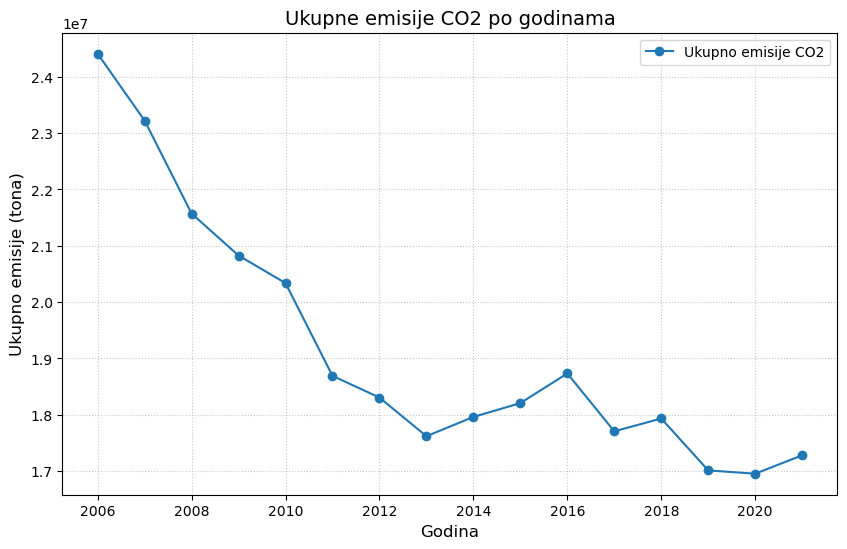

In [128]:
# Vizualizacija emisije po sektorima
plt.figure(figsize=(10, 6))
plt.plot(df_emisije_co2_ukupno["Godina"], df_emisije_co2_ukupno["Ukupno"], marker='o', label='Ukupno emisije CO2')

plt.title("Ukupne emisije CO2 po godinama", fontsize=14)
plt.xlabel("Godina", fontsize=12)
plt.ylabel("Ukupno emisije (tona)", fontsize=12)
plt.grid(True, linestyle=':', alpha=0.7)
plt.legend()
plt.show()

Graf se usklaƒëuje sa grafom na internetu, ≈°to znaƒçi da su podaci uspje≈°no preneseni!

#### Prikupljanje podataka o osunƒçanosti
Sve slike preuzete su sa sljedeƒáe stranice: https://abcgeografija.com/teme/insolacija/ <br>
Slika o ≈æupanijama je preuzeta sa: https://www.kroatien-gastgeber.com/landkreise.html

Na ≈æalost nisam uspio pronaƒái izvor na interneti gdje su podaci o osunƒçanost uneseni putem tablice, veƒá jedino putem slika.<br>
Stoga sam i ovaj put koristio ChatGPT da mi uskrati vrijeme pretvaranja podataka sa slika:
- *"Jel ti mogu poslati sliku koja prikazuje srednju godi≈°nju osunƒçanost u satima, te da na temelju slike, napravi≈° listu rijeƒçnika? Takoƒëer, poslat ƒáu ti i sliku koja pokazuje gdje se koja ≈æupanija nalazi kako bi spremanje podataka bilo toƒçnije"*  - **JA**
- *"Naravno, mo≈æete mi poslati slike koje prikazuju srednju godi≈°nju osunƒçanost u satima i kartu koja jasno pokazuje gdje se nalazi svaka ≈æupanija. Na temelju tih slika mogu generirati odgovarajuƒái Python kod koji ƒáe sadr≈æavati podatke o osunƒçanosti za svaku ≈æupaniju, poput minimalne i maksimalne osunƒçanosti u satima, ≈°to ƒáe vam omoguƒáiti daljnju analizu."* - **ChatGPT**


Slika koja prikazuje srednju godi≈°nju osunƒçanost Hrvatske u satima:

![alt text](resources/images/sunlight_exposure.jpg)

Sa slike vidimo jasno vidimo razlike u bojama. Intenzivnija boja (crvena) oznaƒçava veƒáu osunƒçanost u satima.
- Kako bi analiza bila jednostavnija, napravit ƒáu analizu po ≈æupanijama, umjesto po gradovima

In [129]:
data_osuncanost = [
    {"≈Ωupanija": "Istarska", "Osunƒçavanje (h)": 2400},
    {"≈Ωupanija": "Primorsko-goranska", "Osunƒçavanje (h)": 2200},
    {"≈Ωupanija": "Liƒçko-senjska", "Osunƒçavanje (h)": 2100},
    {"≈Ωupanija": "Zadarska", "Osunƒçavanje (h)": 2500},
    {"≈Ωupanija": "≈†ibensko-kninska", "Osunƒçavanje (h)": 2600},
    {"≈Ωupanija": "Splitsko-dalmatinska", "Osunƒçavanje (h)": 2700},
    {"≈Ωupanija": "Dubrovaƒçko-neretvanska", "Osunƒçavanje (h)": 2700},
    {"≈Ωupanija": "Karlovaƒçka", "Osunƒçavanje (h)": 1800},
    {"≈Ωupanija": "Krapinsko-zagorska", "Osunƒçavanje (h)": 1600},
    {"≈Ωupanija": "Zagrebaƒçka", "Osunƒçavanje (h)": 1650},
    {"≈Ωupanija": "Osjeƒçko-baranjska", "Osunƒçavanje (h)": 1750},
    {"≈Ωupanija": "Vukovarsko-srijemska", "Osunƒçavanje (h)": 1700},
    {"≈Ωupanija": "Brodsko-posavska", "Osunƒçavanje (h)": 1700},
    {"≈Ωupanija": "Virovitiƒçko-podravska", "Osunƒçavanje (h)": 1700},
    {"≈Ωupanija": "Koprivniƒçko-kri≈æevaƒçka", "Osunƒçavanje (h)": 1650},
    {"≈Ωupanija": "Meƒëimurska", "Osunƒçavanje (h)": 1600},
    {"≈Ωupanija": "Vara≈ædinska", "Osunƒçavanje (h)": 1600},
    {"≈Ωupanija": "Sisaƒçko-moslavaƒçka", "Osunƒçavanje (h)": 1750},
    {"≈Ωupanija": "Po≈æe≈°ko-slavonska", "Osunƒçavanje (h)": 1750},
    {"≈Ωupanija": "Bjelovarsko-bilogorska", "Osunƒçavanje (h)": 1700}
]


df_osuncanost = pd.DataFrame(data_osuncanost)
df_osuncanost.head()

≈Ωupanija  Osunƒçavanje (h)
0            Istarska             2400
1  Primorsko-goranska             2200
2       Liƒçko-senjska             2100
3            Zadarska             2500
4    ≈†ibensko-kninska             2600

In [130]:
df_osuncanost.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ≈Ωupanija         20 non-null     object
 1   Osunƒçavanje (h)  20 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 452.0+ bytes


Takoƒëer, na stranici se nalazila i slika koja pokazuje podatke o ozraƒçenosti. Nisam bio siguran jel su mi ti podaci potrebni za kasniju procjenu najboljih mjesta za postavljanje solarnih panela, stoga sam se konzultirao sa ChatGPT-jem:
- *"Jesu li podaci o ozraƒçenosti potrebni za predviƒëanje najboljih lokacija za postavljanje sunƒçanih panela? Trenutno imam samo podatke o osunƒçavanju."* - **JA**
- *"Da, podaci o ozraƒçenosti (koliƒçini sunƒçevog zraƒçenja izra≈æenoj u kWh/m¬≤) su kljuƒçni za precizno predviƒëanje najboljih lokacija za postavljanje sunƒçanih panela. Iako podaci o osunƒçavanju (sati sunƒçeve svjetlosti godi≈°nje) pru≈æaju dobar uvid u potencijal lokacije, sami po sebi nisu dovoljni za tehniƒçke i financijske procjene. Ozraƒçenost izravno utjeƒçe na koliƒçinu proizvedene elektriƒçne energije i omoguƒáuje detaljnije izraƒçune isplativosti i uƒçinkovitosti solarnih panela. Stoga se preporuƒçuje da, uz podatke o osunƒçavanju, prikupite i podatke o godi≈°njoj ozraƒçenosti kako biste dobili potpuniju analizu."* - **ChatGPT**

Slika koja prikazuje ozracenost Hrvatske:

![alt text](resources/images/solar_radiation.jpg)

In [131]:
data_ozracenost = [
    {"≈Ωupanija": "Istarska", "Min Ozraƒçenost (kWh/m¬≤)": 3.5, "Max Ozraƒçenost (kWh/m¬≤)": 3.8},
    {"≈Ωupanija": "Primorsko-goranska", "Min Ozraƒçenost (kWh/m¬≤)": 3.4, "Max Ozraƒçenost (kWh/m¬≤)": 3.7},
    {"≈Ωupanija": "Liƒçko-senjska", "Min Ozraƒçenost (kWh/m¬≤)": 3.8, "Max Ozraƒçenost (kWh/m¬≤)": 4.2},
    {"≈Ωupanija": "Zadarska", "Min Ozraƒçenost (kWh/m¬≤)": 4.2, "Max Ozraƒçenost (kWh/m¬≤)": 4.5},
    {"≈Ωupanija": "≈†ibensko-kninska", "Min Ozraƒçenost (kWh/m¬≤)": 4.3, "Max Ozraƒçenost (kWh/m¬≤)": 4.6},
    {"≈Ωupanija": "Splitsko-dalmatinska", "Min Ozraƒçenost (kWh/m¬≤)": 4.4, "Max Ozraƒçenost (kWh/m¬≤)": 4.6},
    {"≈Ωupanija": "Dubrovaƒçko-neretvanska", "Min Ozraƒçenost (kWh/m¬≤)": 4.3, "Max Ozraƒçenost (kWh/m¬≤)": 4.6},
    {"≈Ωupanija": "Karlovaƒçka", "Min Ozraƒçenost (kWh/m¬≤)": 3.1, "Max Ozraƒçenost (kWh/m¬≤)": 3.4},
    {"≈Ωupanija": "Krapinsko-zagorska", "Min Ozraƒçenost (kWh/m¬≤)": 2.7, "Max Ozraƒçenost (kWh/m¬≤)": 3.0},
    {"≈Ωupanija": "Zagrebaƒçka", "Min Ozraƒçenost (kWh/m¬≤)": 2.7, "Max Ozraƒçenost (kWh/m¬≤)": 3.0},
    {"≈Ωupanija": "Osjeƒçko-baranjska", "Min Ozraƒçenost (kWh/m¬≤)": 3.1, "Max Ozraƒçenost (kWh/m¬≤)": 3.4},
    {"≈Ωupanija": "Vukovarsko-srijemska", "Min Ozraƒçenost (kWh/m¬≤)": 3.1, "Max Ozraƒçenost (kWh/m¬≤)": 3.4},
    {"≈Ωupanija": "Brodsko-posavska", "Min Ozraƒçenost (kWh/m¬≤)": 3.0, "Max Ozraƒçenost (kWh/m¬≤)": 3.3},
    {"≈Ωupanija": "Virovitiƒçko-podravska", "Min Ozraƒçenost (kWh/m¬≤)": 3.0, "Max Ozraƒçenost (kWh/m¬≤)": 3.3},
    {"≈Ωupanija": "Koprivniƒçko-kri≈æevaƒçka", "Min Ozraƒçenost (kWh/m¬≤)": 2.7, "Max Ozraƒçenost (kWh/m¬≤)": 3.0},
    {"≈Ωupanija": "Meƒëimurska", "Min Ozraƒçenost (kWh/m¬≤)": 2.6, "Max Ozraƒçenost (kWh/m¬≤)": 2.9},
    {"≈Ωupanija": "Vara≈ædinska", "Min Ozraƒçenost (kWh/m¬≤)": 2.6, "Max Ozraƒçenost (kWh/m¬≤)": 2.9},
    {"≈Ωupanija": "Sisaƒçko-moslavaƒçka", "Min Ozraƒçenost (kWh/m¬≤)": 3.0, "Max Ozraƒçenost (kWh/m¬≤)": 3.3},
    {"≈Ωupanija": "Po≈æe≈°ko-slavonska", "Min Ozraƒçenost (kWh/m¬≤)": 3.0, "Max Ozraƒçenost (kWh/m¬≤)": 3.3},
    {"≈Ωupanija": "Bjelovarsko-bilogorska", "Min Ozraƒçenost (kWh/m¬≤)": 3.0, "Max Ozraƒçenost (kWh/m¬≤)": 3.3}
]

df_ozracenost = pd.DataFrame(data_ozracenost)
df_ozracenost["Prosjeƒçna Ozraƒçenost (kWh/m¬≤)"] = (df_ozracenost["Min Ozraƒçenost (kWh/m¬≤)"] + df_ozracenost["Max Ozraƒçenost (kWh/m¬≤)"]) / 2
df_ozracenost.head()

≈Ωupanija  Min Ozraƒçenost (kWh/m¬≤)  Max Ozraƒçenost (kWh/m¬≤)  \
0            Istarska                      3.5                      3.8   
1  Primorsko-goranska                      3.4                      3.7   
2       Liƒçko-senjska                      3.8                      4.2   
3            Zadarska                      4.2                      4.5   
4    ≈†ibensko-kninska                      4.3                      4.6   

   Prosjeƒçna Ozraƒçenost (kWh/m¬≤)  
0                           3.65  
1                           3.55  
2                           4.00  
3                           4.35  
4                           4.45

In [132]:
df_ozracenost.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 4 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   ≈Ωupanija                       20 non-null     object 
 1   Min Ozraƒçenost (kWh/m¬≤)        20 non-null     float64
 2   Max Ozraƒçenost (kWh/m¬≤)        20 non-null     float64
 3   Prosjeƒçna Ozraƒçenost (kWh/m¬≤)  20 non-null     float64
dtypes: float64(3), object(1)
memory usage: 772.0+ bytes


##### Provjera podataka

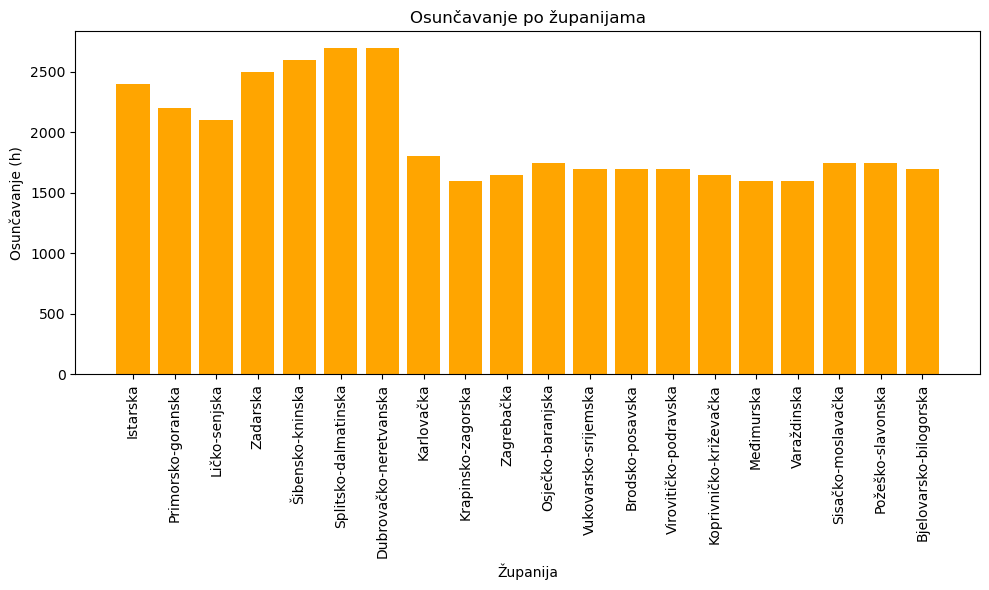

In [133]:
#Provjera podataka za osunƒçanost
zupanije = [zupanija["≈Ωupanija"] for zupanija in data_osuncanost]
osuncanost = [item["Osunƒçavanje (h)"] for item in data_osuncanost]

# Vizualizacija
plt.figure(figsize=(10, 6))
plt.bar(zupanije, osuncanost, color="orange")
plt.xticks(rotation=90)
plt.xlabel("≈Ωupanija")
plt.ylabel("Osunƒçavanje (h)")
plt.title("Osunƒçavanje po ≈æupanijama")
plt.tight_layout()
plt.show()


Usporeƒëujuƒái dobiveni graf i kartu osuncanosti, mogu zakljuƒçiti da su podaci dobro prebaƒçeni!<br>
Najveƒáu osunƒçanost imaju ≈æupanije:
- Splitsko - Dalmatinska
- Dubrovaƒçko - Neretvanska
- ≈†ibensko - Kninska
- Zadarska
- Istarska

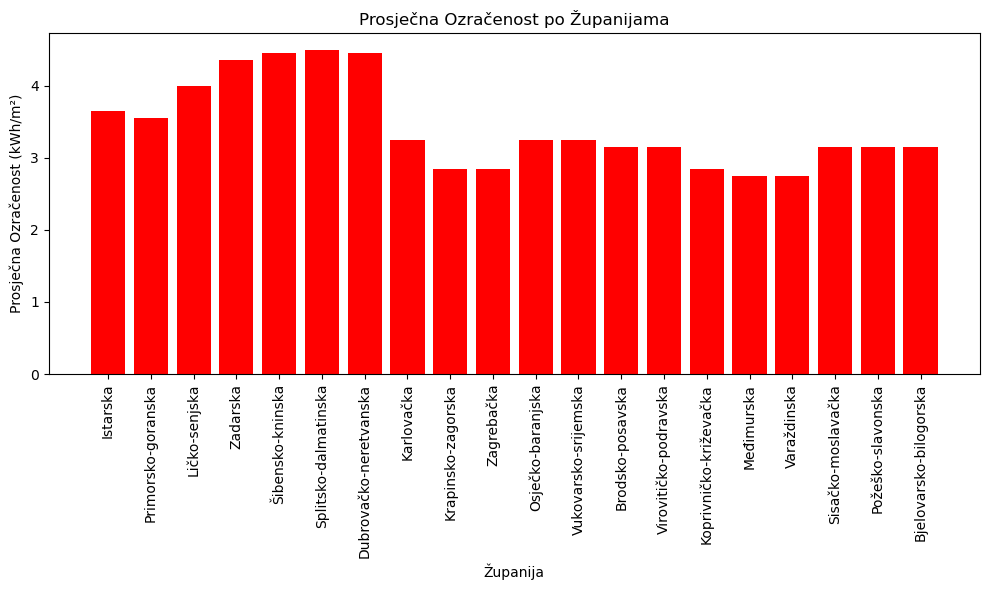

In [134]:
#Provjera podataka za ozraƒçenost
zupanije = df_ozracenost["≈Ωupanija"]
ozracenost = df_ozracenost["Prosjeƒçna Ozraƒçenost (kWh/m¬≤)"]

# Vizualizacija
plt.figure(figsize=(10, 6))
plt.bar(zupanije, ozracenost, color="red")
plt.xticks(rotation=90)
plt.xlabel("≈Ωupanija")
plt.ylabel("Prosjeƒçna Ozraƒçenost (kWh/m¬≤)")
plt.title("Prosjeƒçna Ozraƒçenost po ≈Ωupanijama")
plt.tight_layout()
plt.show()

Sa grafa vidimo kako najveƒáu prosjeƒçnu ozraƒçenost imaju ≈æupanije:
- Zadarska,
- ≈†ibensko - Kninska,
- Splitsko - Dalmatinska 
- Dubrovaƒçko - Neretvanska

Ove ≈æupanije su na krati ozraƒçenosti oznaƒçene sa crvenom bojom ≈°to predstavlja veliku ozraƒçenost. Stoga su i podaci o ozraƒçenosti uspje≈°no prikupljeni.

#### Prikupljanje podataka o brzini i snazi vjetra
Preuzeto sa: https://meteo.hr/klima.php?section=klima_hrvatska&param=k1_8

Navedena stranica sadr≈æi 4 slike koje predstavljaju srednje godi≈°nje brzine i snage vjetra. Dostupni su podaci o vjetru koji se nalazi na visini 10m iznad tla, te na visini 80m iznad tla. Kako su vjetrenjaƒçe dosta vi≈°e od 10m, (bli≈æe 80m nego 10m), koristiti ƒáu podatke za 80m. Takoƒëer, podaci su prikupljeni pomocu ChatGPT-a, kao i za ozraƒçenost i osunƒçanost. Takoƒëer, nisam bio siguran jesu li mi potrebne informacije o srednjoj gustoƒái snage vjetra, stoga sam se konzultirao sa Chatom:
- *"Kako bih procjenio idealno mjesto za vjetrenjaƒçe u Hrvatskoj, jesu li mi potrebni podaci od srednjoj godi≈°njoj gustoƒái snage vjetra uz srednje godi≈°nje brzine vjetra? Takoƒëer, koja je razlika izmeƒáu tih dviju informacija?"* - **JA**
- *"Srednja godi≈°nja gustoƒáa snage vjetra i srednje godi≈°nje brzine vjetra su obje kljuƒçne informacije za procjenu idealnih mjesta za postavljanje vjetrenjaƒça u Hrvatskoj. Brzina vjetra daje osnovnu informaciju o tome koliko je podruƒçje vjetrovito, ali sama brzina nije dovoljna jer energija vjetra raste s treƒáom potencijom brzine (E ‚àù v¬≥). S druge strane, gustoƒáa snage vjetra predstavlja direktnu energetsku vrijednost vjetra na odreƒëenoj visini i ovisi ne samo o brzini vjetra, veƒá i o gustoƒái zraka. Stoga, gustoƒáa snage vjetra daje toƒçniju procjenu potencijala podruƒçja za proizvodnju energije i kljuƒçna je za izbor lokacije vjetrenjaƒçe. U kombinaciji s podacima o brzini vjetra, omoguƒáava detaljniju analizu kako bi se identificirale optimalne lokacije."* - **ChatGPT**

In [135]:
# Podaci o prosjeƒçnoj brzini vjetra
data_brzina_vjetra = [
    {"≈Ωupanija": "Istarska", "Min Brzina vjetra (m/s)": 4.0, "Max Brzina vjetra (m/s)": 4.5, "Prosjek Brzine vjetra (m/s)": 4.25},
    {"≈Ωupanija": "Splitsko-dalmatinska", "Min Brzina vjetra (m/s)": 7.0, "Max Brzina vjetra (m/s)": 7.5, "Prosjek Brzine vjetra (m/s)": 7.00},
    {"≈Ωupanija": "Liƒçko-senjska", "Min Brzina vjetra (m/s)": 6.0, "Max Brzina vjetra (m/s)": 10.0, "Prosjek Brzine vjetra (m/s)": 8.00},
    {"≈Ωupanija": "Zadarska", "Min Brzina vjetra (m/s)": 7.0, "Max Brzina vjetra (m/s)": 8.0, "Prosjek Brzine vjetra (m/s)": 7.50},
    {"≈Ωupanija": "≈†ibensko-kninska", "Min Brzina vjetra (m/s)": 7.0, "Max Brzina vjetra (m/s)": 7.5, "Prosjek Brzine vjetra (m/s)": 7.25},
    {"≈Ωupanija": "Primorsko-goranska", "Min Brzina vjetra (m/s)": 7.5, "Max Brzina vjetra (m/s)": 8.0, "Prosjek Brzine vjetra (m/s)": 7.75},
    {"≈Ωupanija": "Dubrovaƒçko-neretvanska", "Min Brzina vjetra (m/s)": 7.0, "Max Brzina vjetra (m/s)": 7.5, "Prosjek Brzine vjetra (m/s)": 7.25},
    {"≈Ωupanija": "Karlovaƒçka", "Min Brzina vjetra (m/s)": 3.5, "Max Brzina vjetra (m/s)": 4.0, "Prosjek Brzine vjetra (m/s)": 3.75},
    {"≈Ωupanija": "Bjelovarsko-bilogorska", "Min Brzina vjetra (m/s)": 2.0, "Max Brzina vjetra (m/s)": 2.5, "Prosjek Brzine vjetra (m/s)": 2.25},
    {"≈Ωupanija": "Zagrebaƒçka", "Min Brzina vjetra (m/s)": 2.0, "Max Brzina vjetra (m/s)": 2.5, "Prosjek Brzine vjetra (m/s)": 2.25},
    {"≈Ωupanija": "Krapinsko-zagorska", "Min Brzina vjetra (m/s)": 2.0, "Max Brzina vjetra (m/s)": 2.5, "Prosjek Brzine vjetra (m/s)": 2.25},
    {"≈Ωupanija": "Vara≈ædinska", "Min Brzina vjetra (m/s)": 1.5, "Max Brzina vjetra (m/s)": 2.0, "Prosjek Brzine vjetra (m/s)": 1.75},
    {"≈Ωupanija": "Koprivniƒçko-kri≈æevaƒçka", "Min Brzina vjetra (m/s)": 2.0, "Max Brzina vjetra (m/s)": 2.5, "Prosjek Brzine vjetra (m/s)": 2.25},
    {"≈Ωupanija": "Meƒëimurska", "Min Brzina vjetra (m/s)": 1.5, "Max Brzina vjetra (m/s)": 2.0, "Prosjek Brzine vjetra (m/s)": 1.75},
    {"≈Ωupanija": "Virovitiƒçko-podravska", "Min Brzina vjetra (m/s)": 2.5, "Max Brzina vjetra (m/s)": 3.0, "Prosjek Brzine vjetra (m/s)": 2.75},
    {"≈Ωupanija": "Osjeƒçko-baranjska", "Min Brzina vjetra (m/s)": 3.0, "Max Brzina vjetra (m/s)": 3.5, "Prosjek Brzine vjetra (m/s)": 3.25},
    {"≈Ωupanija": "Brodsko-posavska", "Min Brzina vjetra (m/s)": 3.0, "Max Brzina vjetra (m/s)": 3.5, "Prosjek Brzine vjetra (m/s)": 3.25},
    {"≈Ωupanija": "Po≈æe≈°ko-slavonska", "Min Brzina vjetra (m/s)": 3.0, "Max Brzina vjetra (m/s)": 3.5, "Prosjek Brzine vjetra (m/s)": 3.25},
    {"≈Ωupanija": "Sisaƒçko-moslavaƒçka", "Min Brzina vjetra (m/s)": 3.5, "Max Brzina vjetra (m/s)": 4.0, "Prosjek Brzine vjetra (m/s)": 3.75},
    {"≈Ωupanija": "Vukovarsko-srijemska", "Min Brzina vjetra (m/s)": 3.0, "Max Brzina vjetra (m/s)": 3.5, "Prosjek Brzine vjetra (m/s)": 3.25}
    
]

df_brzina_vjetra = pd.DataFrame(data_brzina_vjetra)
df_brzina_vjetra = df_brzina_vjetra.sort_values(by="Prosjek Brzine vjetra (m/s)", ascending=False)
df_brzina_vjetra.head()

≈Ωupanija  Min Brzina vjetra (m/s)  Max Brzina vjetra (m/s)  \
2           Liƒçko-senjska                      6.0                     10.0   
5      Primorsko-goranska                      7.5                      8.0   
3                Zadarska                      7.0                      8.0   
4        ≈†ibensko-kninska                      7.0                      7.5   
6  Dubrovaƒçko-neretvanska                      7.0                      7.5   

   Prosjek Brzine vjetra (m/s)  
2                         8.00  
5                         7.75  
3                         7.50  
4                         7.25  
6                         7.25

In [136]:
df_brzina_vjetra.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20 entries, 2 to 11
Data columns (total 4 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ≈Ωupanija                     20 non-null     object 
 1   Min Brzina vjetra (m/s)      20 non-null     float64
 2   Max Brzina vjetra (m/s)      20 non-null     float64
 3   Prosjek Brzine vjetra (m/s)  20 non-null     float64
dtypes: float64(3), object(1)
memory usage: 800.0+ bytes


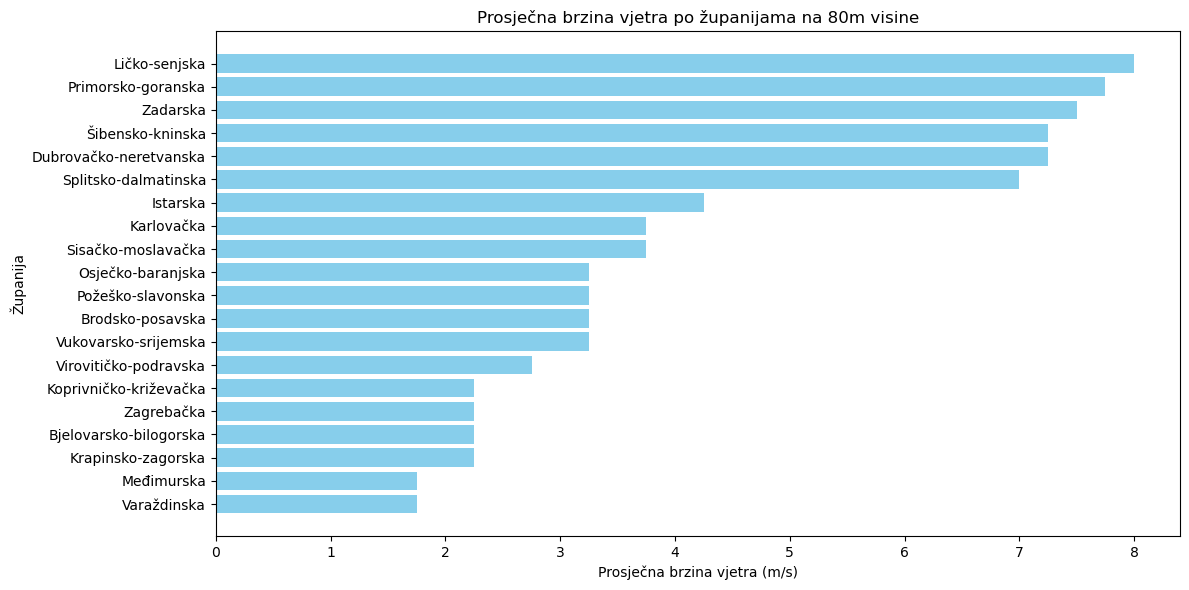

In [137]:
# Vizualizacija
plt.figure(figsize=(12,6))
plt.barh(df_brzina_vjetra["≈Ωupanija"], df_brzina_vjetra["Prosjek Brzine vjetra (m/s)"], color='skyblue')
plt.xlabel("Prosjeƒçna brzina vjetra (m/s)")
plt.ylabel("≈Ωupanija")
plt.title("Prosjeƒçna brzina vjetra po ≈æupanijama na 80m visine")
plt.gca().invert_yaxis()  # Inverzija reda za bolje ƒçitanje
plt.tight_layout()
plt.show()

Najveƒáe brzine vjetra na visini od 80 m iznad tla imaju sljedeƒáe ≈æupanije:
- Liƒçko - Senjska
- Primorsko - Ogranska
- Zadarska
- ≈†ibensko - Kninska
- Dubrovaƒçko Neretvanska
- Splitsko - Dalmatinska

Ovi rezultati se poklapaju sa ≈æupanijama na karti koja prikazuje srednje godisnje brzine vjetrova.

In [138]:
# Prikupljanje podataka za snagu vjetra
data_gustoca_snage_vjetra = [
    {"≈Ωupanija": "Istarska", "Min Gustoƒáa snage (W/m¬≤)": 250, "Max Gustoƒáa snage (W/m¬≤)": 450, "Prosjek Gustoƒáe snage (W/m¬≤)": 350},
    {"≈Ωupanija": "Zadarska", "Min Gustoƒáa snage (W/m¬≤)": 900, "Max Gustoƒáa snage (W/m¬≤)": 1100, "Prosjek Gustoƒáe snage (W/m¬≤)": 1000},
    {"≈Ωupanija": "Liƒçko-senjska", "Min Gustoƒáa snage (W/m¬≤)": 1100, "Max Gustoƒáa snage (W/m¬≤)": 1350, "Prosjek Gustoƒáe snage (W/m¬≤)": 1225},
    {"≈Ωupanija": "Primorsko-goranska", "Min Gustoƒáa snage (W/m¬≤)": 1000, "Max Gustoƒáa snage (W/m¬≤)": 1250, "Prosjek Gustoƒáe snage (W/m¬≤)": 1125},
    {"≈Ωupanija": "≈†ibensko-kninska", "Min Gustoƒáa snage (W/m¬≤)": 900, "Max Gustoƒáa snage (W/m¬≤)": 1100, "Prosjek Gustoƒáe snage (W/m¬≤)": 1000},
    {"≈Ωupanija": "Splitsko-dalmatinska", "Min Gustoƒáa snage (W/m¬≤)": 850, "Max Gustoƒáa snage (W/m¬≤)": 1050, "Prosjek Gustoƒáe snage (W/m¬≤)": 950},
    {"≈Ωupanija": "Dubrovaƒçko-neretvanska", "Min Gustoƒáa snage (W/m¬≤)": 850, "Max Gustoƒáa snage (W/m¬≤)": 1050, "Prosjek Gustoƒáe snage (W/m¬≤)": 950},
    {"≈Ωupanija": "Karlovaƒçka", "Min Gustoƒáa snage (W/m¬≤)": 250, "Max Gustoƒáa snage (W/m¬≤)": 400, "Prosjek Gustoƒáe snage (W/m¬≤)": 325},
    {"≈Ωupanija": "Bjelovarsko-bilogorska", "Min Gustoƒáa snage (W/m¬≤)": 200, "Max Gustoƒáa snage (W/m¬≤)": 300, "Prosjek Gustoƒáe snage (W/m¬≤)": 250},
    {"≈Ωupanija": "Zagrebaƒçka", "Min Gustoƒáa snage (W/m¬≤)": 200, "Max Gustoƒáa snage (W/m¬≤)": 300, "Prosjek Gustoƒáe snage (W/m¬≤)": 250},
    {"≈Ωupanija": "Krapinsko-zagorska", "Min Gustoƒáa snage (W/m¬≤)": 150, "Max Gustoƒáa snage (W/m¬≤)": 250, "Prosjek Gustoƒáe snage (W/m¬≤)": 200},
    {"≈Ωupanija": "Vara≈ædinska", "Min Gustoƒáa snage (W/m¬≤)": 100, "Max Gustoƒáa snage (W/m¬≤)": 200, "Prosjek Gustoƒáe snage (W/m¬≤)": 150},
    {"≈Ωupanija": "Koprivniƒçko-kri≈æevaƒçka", "Min Gustoƒáa snage (W/m¬≤)": 150, "Max Gustoƒáa snage (W/m¬≤)": 250, "Prosjek Gustoƒáe snage (W/m¬≤)": 200},
    {"≈Ωupanija": "Meƒëimurska", "Min Gustoƒáa snage (W/m¬≤)": 100, "Max Gustoƒáa snage (W/m¬≤)": 200, "Prosjek Gustoƒáe snage (W/m¬≤)": 150},
    {"≈Ωupanija": "Virovitiƒçko-podravska", "Min Gustoƒáa snage (W/m¬≤)": 200, "Max Gustoƒáa snage (W/m¬≤)": 300, "Prosjek Gustoƒáe snage (W/m¬≤)": 250},
    {"≈Ωupanija": "Osjeƒçko-baranjska", "Min Gustoƒáa snage (W/m¬≤)": 250, "Max Gustoƒáa snage (W/m¬≤)": 400, "Prosjek Gustoƒáe snage (W/m¬≤)": 325},
    {"≈Ωupanija": "Brodsko-posavska", "Min Gustoƒáa snage (W/m¬≤)": 250, "Max Gustoƒáa snage (W/m¬≤)": 400, "Prosjek Gustoƒáe snage (W/m¬≤)": 325},
    {"≈Ωupanija": "Po≈æe≈°ko-slavonska", "Min Gustoƒáa snage (W/m¬≤)": 300, "Max Gustoƒáa snage (W/m¬≤)": 450, "Prosjek Gustoƒáe snage (W/m¬≤)": 375},
    {"≈Ωupanija": "Sisaƒçko-moslavaƒçka", "Min Gustoƒáa snage (W/m¬≤)": 300, "Max Gustoƒáa snage (W/m¬≤)": 450, "Prosjek Gustoƒáe snage (W/m¬≤)": 375},
    {"≈Ωupanija": "Vukovarsko-srijemska", "Min Gustoƒáa snage (W/m¬≤)": 200, "Max Gustoƒáa snage (W/m¬≤)": 300, "Prosjek Gustoƒáe snage (W/m¬≤)": 250}
]


df_gustoca_snage_vjetra = pd.DataFrame(data_gustoca_snage_vjetra)
df_gustoca_snage_vjetra = df_gustoca_snage_vjetra.sort_values(by="Prosjek Gustoƒáe snage (W/m¬≤)", ascending=True)
df_gustoca_snage_vjetra.head()

≈Ωupanija  Min Gustoƒáa snage (W/m¬≤)  \
13              Meƒëimurska                       100   
11             Vara≈ædinska                       100   
12  Koprivniƒçko-kri≈æevaƒçka                       150   
10      Krapinsko-zagorska                       150   
9               Zagrebaƒçka                       200   

    Max Gustoƒáa snage (W/m¬≤)  Prosjek Gustoƒáe snage (W/m¬≤)  
13                       200                           150  
11                       200                           150  
12                       250                           200  
10                       250                           200  
9                        300                           250

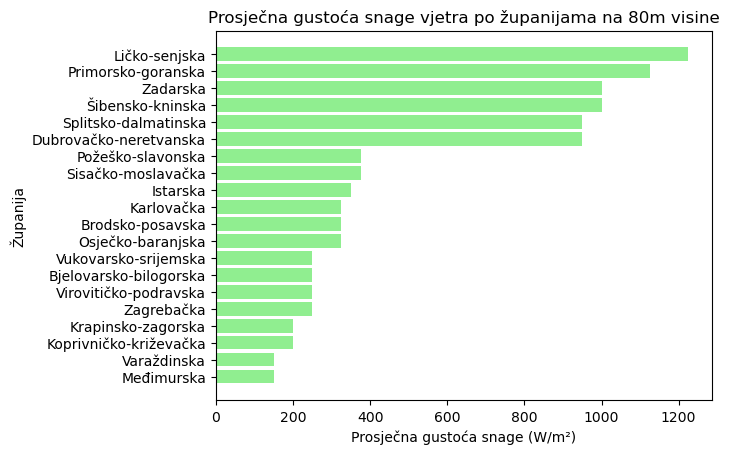

In [139]:
# Vizualizacija
plt.barh(df_gustoca_snage_vjetra["≈Ωupanija"], df_gustoca_snage_vjetra["Prosjek Gustoƒáe snage (W/m¬≤)"], color='lightgreen')
plt.xlabel("Prosjeƒçna gustoƒáa snage (W/m¬≤)")
plt.ylabel("≈Ωupanija")
plt.title("Prosjeƒçna gustoƒáa snage vjetra po ≈æupanijama na 80m visine")
plt.show()

Podaci su usklaƒëeni sa kartom i sa podacima o srednjoj godi≈°njoj brzini vjetra za pojedinu ≈æupaniju.

Sada kada su svi potrebni podaci uneseni, mogu krenuti sa izradom baze podataka.

---

### 2. Izrada baze podataka

Kako bih se upoznao sa sqlite3 bibliotekom, koristio sam sljedeƒáe izvore:
- https://www.youtube.com/watch?v=girsuXz0yA8
- https://www.youtube.com/watch?v=5LpotBtmZZs

In [140]:
# Kreiranje baze
connection = db.connect('data/project_data.db')

In [141]:
# Kreiranje kursora -> omoguƒáuje izvr≈°avanje SQL upita
cur = connection.cursor()

In [142]:
# Provjera podataka prije unosa u tablicu
print(df_osuncanost.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ≈Ωupanija         20 non-null     object
 1   Osunƒçavanje (h)  20 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 452.0+ bytes
None


In [143]:
print(df_ozracenost.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 4 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   ≈Ωupanija                       20 non-null     object 
 1   Min Ozraƒçenost (kWh/m¬≤)        20 non-null     float64
 2   Max Ozraƒçenost (kWh/m¬≤)        20 non-null     float64
 3   Prosjeƒçna Ozraƒçenost (kWh/m¬≤)  20 non-null     float64
dtypes: float64(3), object(1)
memory usage: 772.0+ bytes
None


In [144]:
print(df_brzina_vjetra.info())

<class 'pandas.core.frame.DataFrame'>
Index: 20 entries, 2 to 11
Data columns (total 4 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ≈Ωupanija                     20 non-null     object 
 1   Min Brzina vjetra (m/s)      20 non-null     float64
 2   Max Brzina vjetra (m/s)      20 non-null     float64
 3   Prosjek Brzine vjetra (m/s)  20 non-null     float64
dtypes: float64(3), object(1)
memory usage: 800.0+ bytes
None


In [145]:
print(df_gustoca_snage_vjetra.info())

<class 'pandas.core.frame.DataFrame'>
Index: 20 entries, 13 to 2
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   ≈Ωupanija                      20 non-null     object
 1   Min Gustoƒáa snage (W/m¬≤)      20 non-null     int64 
 2   Max Gustoƒáa snage (W/m¬≤)      20 non-null     int64 
 3   Prosjek Gustoƒáe snage (W/m¬≤)  20 non-null     int64 
dtypes: int64(3), object(1)
memory usage: 800.0+ bytes
None


Sada kada znam kojeg su tipa koji stupci iz pojedinih tablica, mogu krenuti sa izradom tablica

In [146]:
# Spajanje glavnih stupca iz svakog DataFrame-a u jedan DataFrame kako bi unos podataka bio jednostavniji - Spajanje podataka prema stupcu ≈Ωupanija
df_klima = df_osuncanost.merge(df_ozracenost[["≈Ωupanija", "Prosjeƒçna Ozraƒçenost (kWh/m¬≤)"]], on="≈Ωupanija", how="inner")
df_klima = df_klima.merge(df_brzina_vjetra[["≈Ωupanija", "Prosjek Brzine vjetra (m/s)"]], on="≈Ωupanija", how="inner")
df_klima = df_klima.merge(df_gustoca_snage_vjetra[["≈Ωupanija", "Prosjek Gustoƒáe snage (W/m¬≤)"]], on="≈Ωupanija", how="inner")

print(df_klima.head())

             ≈Ωupanija  Osunƒçavanje (h)  Prosjeƒçna Ozraƒçenost (kWh/m¬≤)  \
0            Istarska             2400                           3.65   
1  Primorsko-goranska             2200                           3.55   
2       Liƒçko-senjska             2100                           4.00   
3            Zadarska             2500                           4.35   
4    ≈†ibensko-kninska             2600                           4.45   

   Prosjek Brzine vjetra (m/s)  Prosjek Gustoƒáe snage (W/m¬≤)  
0                         4.25                           350  
1                         7.75                          1125  
2                         8.00                          1225  
3                         7.50                          1000  
4                         7.25                          1000  


In [147]:
# Provjera podataka:
df_klima.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   ≈Ωupanija                       20 non-null     object 
 1   Osunƒçavanje (h)                20 non-null     int64  
 2   Prosjeƒçna Ozraƒçenost (kWh/m¬≤)  20 non-null     float64
 3   Prosjek Brzine vjetra (m/s)    20 non-null     float64
 4   Prosjek Gustoƒáe snage (W/m¬≤)   20 non-null     int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 932.0+ bytes


In [148]:
kreiranje_tablice_klima = """CREATE TABLE IF NOT EXISTS klima
                (zupanija_id INTEGER PRIMARY KEY AUTOINCREMENT,
                zupanija TEXT NOT NULL,
                osuncanost_h INTEGER NOT NULL,
                prosjecna_ozracenost_kwh_m2 FLOAT NOT NULL,
                prosjek_brzine_vjetra_ms FLOAT NOT NULL,
                prosjek_gustoca_snage_w_m2 INTEGER NOT NULL);"""

cur.execute(kreiranje_tablice_klima)

In [149]:
# Unos podataka
df_klima.to_sql("klima", connection, if_exists="replace", index=False)

20

In [150]:
df_provjera1 = pd.read_sql_query("select * from klima", connection)
df_provjera1

≈Ωupanija  Osunƒçavanje (h)  Prosjeƒçna Ozraƒçenost (kWh/m¬≤)  \
0                 Istarska             2400                           3.65   
1       Primorsko-goranska             2200                           3.55   
2            Liƒçko-senjska             2100                           4.00   
3                 Zadarska             2500                           4.35   
4         ≈†ibensko-kninska             2600                           4.45   
5     Splitsko-dalmatinska             2700                           4.50   
6   Dubrovaƒçko-neretvanska             2700                           4.45   
7               Karlovaƒçka             1800                           3.25   
8       Krapinsko-zagorska             1600                           2.85   
9               Zagrebaƒçka             1650                           2.85   
10       Osjeƒçko-baranjska             1750                           3.25   
11    Vukovarsko-srijemska             1700                           3.25   
12        Brodsko-posavska             1700                           3.15   
13   Virovitiƒçko-podravska             1700                           3.15   
14  Koprivniƒçko-kri≈æevaƒçka             1650                           2.85   
15              Meƒëimurska             1600                           2.75   
16             Vara≈ædinska             1600                           2.75   
17      Sisaƒçko-moslavaƒçka             1750                           3.15   
18       Po≈æe≈°ko-slavonska             1750                           3.15   
19  Bjelovarsko-bilogorska             1700                           3.15   

    Prosjek Brzine vjetra (m/s)  Prosjek Gustoƒáe snage (W/m¬≤)  
0                          4.25                           350  
1                          7.75                          1125  
2                          8.00                          1225  
3                          7.50                          1000  
4                          7.25                          1000  
5                          7.00                           950  
6                          7.25                           950  
7                          3.75                           325  
8                          2.25                           200  
9                          2.25                           250  
10                         3.25                           325  
11                         3.25                           250  
12                         3.25                           325  
13                         2.75                           250  
14                         2.25                           200  
15                         1.75                           150  
16                         1.75                           150  
17                         3.75                           375  
18                         3.25                           375  
19                         2.25                           250

In [151]:
# Provjera podataka
df_emisije_co2_ukupno.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   Godina                      16 non-null     int64
 1   Energetika                  16 non-null     int64
 2   Poljoprivreda               16 non-null     int64
 3   Industrijsko sagorijevanje  16 non-null     int64
 4   Transport                   16 non-null     int64
 5   Zgrade                      16 non-null     int64
 6   Eksploatacija goriva        16 non-null     int64
 7   Otpad                       16 non-null     int64
 8   Procesi                     16 non-null     int64
 9   Ukupno                      16 non-null     int64
dtypes: int64(10)
memory usage: 1.4 KB


In [152]:
kreiranje_tablice_ugljik = """CREATE TABLE IF NOT EXISTS ugljik (
                godina INTEGER PRIMARY KEY,
                energetika INTEGER NOT NULL,
                poljoprivreda INTEGER NOT NULL,
                industrijsko_sagorijevanje INTEGER NOT NULL,
                transport INTEGER NOT NULL,
                zgrade INTEGER NOT NULL,
                eksploatacija_goriva INTEGER NOT NULL,
                otpad INTEGER NOT NULL,
                procesi INTEGER NOT NULL,
                ukupno INTEGER NOT NULL);"""

cur.execute(kreiranje_tablice_ugljik)

In [153]:
# Unos podataka
df_emisije_co2_ukupno.to_sql("ugljik", connection, if_exists="replace", index=False)

16

In [154]:
df_provjera2 = pd.read_sql_query("select * from ugljik", connection)
df_provjera2

Godina  Energetika  Poljoprivreda  Industrijsko sagorijevanje  Transport  \
0     2006     5969430          97640                     3659360    6214300   
1     2007     5373390          99000                     3688280    6144560   
2     2008     4564120          61440                     3000720    6112640   
3     2009     4234580          87370                     2838090    5871590   
4     2010     4455410          80140                     2629920    5756760   
5     2011     4041780          94290                     2290220    5550430   
6     2012     3827160          92710                     2267240    5632430   
7     2013     3237490          78570                     2222300    5577130   
8     2014     3297330          95860                     2148480    5885330   
9     2015     3550030          99000                     2146040    6099740   
10    2016     3139770          90510                     2313350    6573080   
11    2017     2593240          90200                     2333650    6336500   
12    2018     2857270          91300                     2322250    6510660   
13    2019     2845060          98370                     2333370    5705520   
14    2020     2683820         102370                     2349040    6173730   
15    2021     2522590         106980                     2370070    6654930   

     Zgrade  Eksploatacija goriva  Otpad  Procesi    Ukupno  
0   3317600               2059910    430  3089810  24408480  
1   3409240               1550760    440  2956960  23222630  
2   3447570               1940100    110  2445340  21572040  
3   3511910               1795260     30  2488390  20827220  
4   3261970               1844990     30  2308640  20337860  
5   2947620               1553250     60  2214180  18691830  
6   2792280               1370950     30  2323590  18306390  
7   2535870               1458600     30  2510810  17620800  
8   2726870               1392710     30  2415890  17962500  
9   2793140               1238000     30  2282360  18208340  
10  2824700               1284540      0  2508270  18734220  
11  2749290               1254220      0  2350370  17707470  
12  2661090                998970      0  2493510  17935050  
13  2729120                815260      0  2487270  17013970  
14  2603820                802340      0  2239890  16955010  
15  2661090                798060      0  2168520  17282240

In [155]:
# Na kraju je potrebno zatvoriti vezu kursor i konekciju
cur.close()
connection.close()

---

### 3. Analiza i integracija podataka
- M. Medvidoviƒá, "Optimiranje samostalnog hibridnog sustava," diplomski rad, Fakultet elektrotehnike i raƒçunarstva, Sveuƒçili≈°te u Zagrebu, Zagreb, lipanj 2010.
    - https://www.ieee.hr/_download/repository/ZR10MMedvidovic.pdf
- L. Kadi, "Koncept sustava za proizvodnju zelenog vodika uporabom energije vjetra," diplomski rad, Tehniƒçki fakultet, Sveuƒçili≈°te u Rijeci, Rijeka, rujan 2022.
    - https://www.unirepository.svkri.uniri.hr/islandora/object/riteh:3404
- Renewables First - Wind turbine funcamentals
    - https://renewablesfirst.co.uk/renewable-energy-technologies/windpower/windpower-learning-centre/wind-turbine-fundamentals/
- Boston Solar, "How Much CO2 Do Solar Panels Save?", 15. srpanj 2024.
    - https://www.bostonsolar.us/solar-blog-resource-center/blog/how-much-co2-do-solar-panels-save/
- *"Most residential solar panes on today's market are rated to produce between 250 and 400 watts each per hour."* ->YES energy solutions, "How much energy do solar panels produce for your home"
    - https://www.yesenergysolutions.co.uk/advice/how-much-energy-solar-panels-produce-home#:~:text=Most%20residential%20solar%20panels%20on,1%20kW%20and%204%20kW
- *"The transmission and generation (T&D) emissions factor for grdid electricity has increased from 2023 ... to 0.01830 kg CO2 per kWh."* -> BusinessEnergyScotland, "How to calculate your business's carbon footprint"
    - https://businessenergyscotland.org/guides/how-calculate-your-businesss-carbon-footprint/#:~:text=For%20electricity%2C%20the%20calculation%20will,1%2C000%20%3D%203.7tCO2e
- *"It is reckoned that an average onshore wind turbine rated at 2.5 - 3 megawatts can produce in excess of 6 million kWh every year."* -> InspireCleanEnergy, "How Much Power Does A Wind Turbine Produce?"
    - https://www.inspirecleanenergy.com/blog/clean-energy-101/how-much-energy-does-wind-turbine-produce


M. Medvidoviƒá u svojem diplomskom radu navodi da je za vjetrenjaƒçu za idealnu proizvodnju elektriƒçne energije bila potrebna brzina vjetra od oko 12m/s. Isto tako navodi sljedeƒáe: *"Minimalna srednja godi≈°nja brzina vjetra pri kojoj je isplativo izgraditi vjetroelektranu, odnosno donja granica korisnog rada vjetroelektrane je izmeƒëu 4 i 5 m/s."*

L. Kadi u svojem diplomskom radu navodi sljedeƒáe: *"Najveƒái utjecaj na snagu vjetra ima brzina vjetra. Meƒëutim, ni jedna vjetroturbina ne mo≈æe pretvoriti svu kinetiƒçku energiju vjetra u mehaniƒçku energiju na lopaticama rotora. O tome govori Betzovo pravilo, prema kojem se maksimalno 59,3 % kinetiƒçke energije vjetra mo≈æe pretvoriti u korisnu mehaniƒçku energiju"*<br><br>


Nisam uspio pronaƒái konkretne informacije o potrebnoj srednjoj gustoƒái snage vjetra, te i koliki je optimalan broj vjetrenjaƒça da se postavi, stoga sam se konzultirao sa ChatGPT-jem:
- *"Kolika bi srednja godi≈°nja gustoƒáa snage vjetra bila potrebna da bi bilo isplativo postaviti vjetrenjaƒçu, te koliki bi bio optimalan broj vjetrenjaƒça da se u ƒçim br≈æem roku poka≈æe isplativost projekta?"* - **JA**
- *"Za postavljanje vjetrenjaƒçe potrebno je da srednja godi≈°nja gustoƒáa snage vjetra iznosi najmanje 300 W/m¬≤ kako bi projekt bio ekonomski isplativ. Optimalan broj vjetrenjaƒça ovisi o veliƒçini podruƒçja, raspolo≈æivim financijskim sredstvima i ciljevima projekta, no ƒçesto se smatra da se poƒçetni povrat ulaganja mo≈æe postiƒái s 10-20 vjetrenjaƒça na lokacijama s povoljnim uvjetima, pri ƒçemu svaka vjetroturbina mo≈æe proizvesti izmeƒëu 1-3 MW elektriƒçne energije, ovisno o tipu i modelu."* - **ChatGPT**

Renewables First navodi: *"Bilo koja lokacija sa srednjom godi≈°njom brzinom vjetra od 7 m/s ili vi≈°e smatra se izvrsnom za vjetroturbine na farmama. Zapravo, mnoge lokacije s brzinom vjetra od samo 5,5 m/s i dalje mogu biti isplative uz kori≈°tenje vjetroturbina s "predimenzioniranim rotorima" koje su sada dostupne. Ako imate manje od 5 m/s, gotovo sigurno ne bi bilo ekonomski isplativo instalirati vjetroturbinu."*

Nisam uspio ni≈°ta pronaƒái za ozraƒçenost i osunƒçanost za solarne panele, stoga sam pitao Chat:
- *"Nisam ni≈°ta uspio pronaƒái za ozraƒçenost i osunƒçanost za solarne panele koji govore kolike bi trebale biti njihove prosjeƒçne vrijednosti da bi se paneli isplatili. Jel zna≈° ti ne≈°to vi≈°e o tome ili mi mo≈æe≈° dati neke izvore?"* - **JA**
- *"Za isplativu instalaciju solarnih panela, kljuƒçni su podaci o srednjoj godi≈°njoj osunƒçanosti i ozraƒçenosti. Prema podacima Hrvatske energetske regulatorne agencije (HERA), prosjeƒçna godi≈°nja osunƒçanost u Hrvatskoj varira izmeƒëu 2000 i 2700 sati, dok prosjeƒçna godi≈°nja ozraƒçenost iznosi izmeƒëu 1200 i 1600 kWh/m¬≤, ovisno o lokaciji. Ovi podaci ukazuju na povoljne uvjete za kori≈°tenje solarne energije u veƒáem dijelu zemlje. Za detaljnije informacije i preporuke o minimalnim vrijednostima osunƒçanosti i ozraƒçenosti za isplativost solarnih panela, preporuƒçuje se konzultirati struƒçnu literaturu ili nadle≈æne institucije poput HERA-e ili Ministarstva gospodarstva i odr≈æivog razvoja Republike Hrvatske."* - **ChatGPT** - Nije dao nikakve izvore...

Zakljuƒçno
- Vjetrenjaƒçe
    - Brzina vjetra -> veƒáa ili jednaka 7 m/s
    - Gustoƒáa snage -> veƒáa od 300 W/m¬≤
    - Broj ->  ?
    - Smanjenje emisije -> ?
- Solarne panele
    - Ozraƒçenost -> veƒáa ili jednaka 1200 kWh/m¬≤
    - Osunƒçanost -> veƒáa od 2000 sati godi≈°nje
    - Broj -> ?
    - Smanjenje emisije -> ?

In [156]:
df_brzina_vjetra

≈Ωupanija  Min Brzina vjetra (m/s)  Max Brzina vjetra (m/s)  \
2            Liƒçko-senjska                      6.0                     10.0   
5       Primorsko-goranska                      7.5                      8.0   
3                 Zadarska                      7.0                      8.0   
4         ≈†ibensko-kninska                      7.0                      7.5   
6   Dubrovaƒçko-neretvanska                      7.0                      7.5   
1     Splitsko-dalmatinska                      7.0                      7.5   
0                 Istarska                      4.0                      4.5   
7               Karlovaƒçka                      3.5                      4.0   
18      Sisaƒçko-moslavaƒçka                      3.5                      4.0   
15       Osjeƒçko-baranjska                      3.0                      3.5   
17       Po≈æe≈°ko-slavonska                      3.0                      3.5   
16        Brodsko-posavska                      3.0                      3.5   
19    Vukovarsko-srijemska                      3.0                      3.5   
14   Virovitiƒçko-podravska                      2.5                      3.0   
12  Koprivniƒçko-kri≈æevaƒçka                      2.0                      2.5   
9               Zagrebaƒçka                      2.0                      2.5   
8   Bjelovarsko-bilogorska                      2.0                      2.5   
10      Krapinsko-zagorska                      2.0                      2.5   
13              Meƒëimurska                      1.5                      2.0   
11             Vara≈ædinska                      1.5                      2.0   

    Prosjek Brzine vjetra (m/s)  
2                          8.00  
5                          7.75  
3                          7.50  
4                          7.25  
6                          7.25  
1                          7.00  
0                          4.25  
7                          3.75  
18                         3.75  
15                         3.25  
17                         3.25  
16                         3.25  
19                         3.25  
14                         2.75  
12                         2.25  
9                          2.25  
8                          2.25  
10                         2.25  
13                         1.75  
11                         1.75

In [157]:
# ≈Ωupanije s dovoljnom prosjeƒçnom brzinom vjetra
zupanije_brzina = df_brzina_vjetra[df_brzina_vjetra["Prosjek Brzine vjetra (m/s)"] >= 5.5]
zupanije_brzina

≈Ωupanija  Min Brzina vjetra (m/s)  Max Brzina vjetra (m/s)  \
2           Liƒçko-senjska                      6.0                     10.0   
5      Primorsko-goranska                      7.5                      8.0   
3                Zadarska                      7.0                      8.0   
4        ≈†ibensko-kninska                      7.0                      7.5   
6  Dubrovaƒçko-neretvanska                      7.0                      7.5   
1    Splitsko-dalmatinska                      7.0                      7.5   

   Prosjek Brzine vjetra (m/s)  
2                         8.00  
5                         7.75  
3                         7.50  
4                         7.25  
6                         7.25  
1                         7.00

In [158]:
df_gustoca_snage_vjetra

≈Ωupanija  Min Gustoƒáa snage (W/m¬≤)  \
13              Meƒëimurska                       100   
11             Vara≈ædinska                       100   
12  Koprivniƒçko-kri≈æevaƒçka                       150   
10      Krapinsko-zagorska                       150   
9               Zagrebaƒçka                       200   
14   Virovitiƒçko-podravska                       200   
8   Bjelovarsko-bilogorska                       200   
19    Vukovarsko-srijemska                       200   
15       Osjeƒçko-baranjska                       250   
16        Brodsko-posavska                       250   
7               Karlovaƒçka                       250   
0                 Istarska                       250   
18      Sisaƒçko-moslavaƒçka                       300   
17       Po≈æe≈°ko-slavonska                       300   
6   Dubrovaƒçko-neretvanska                       850   
5     Splitsko-dalmatinska                       850   
4         ≈†ibensko-kninska                       900   
1                 Zadarska                       900   
3       Primorsko-goranska                      1000   
2            Liƒçko-senjska                      1100   

    Max Gustoƒáa snage (W/m¬≤)  Prosjek Gustoƒáe snage (W/m¬≤)  
13                       200                           150  
11                       200                           150  
12                       250                           200  
10                       250                           200  
9                        300                           250  
14                       300                           250  
8                        300                           250  
19                       300                           250  
15                       400                           325  
16                       400                           325  
7                        400                           325  
0                        450                           350  
18                       450                           375  
17                       450                           375  
6                       1050                           950  
5                       1050                           950  
4                       1100                          1000  
1                       1100                          1000  
3                       1250                          1125  
2                       1350                          1225

In [159]:
# ≈Ωupanije s dovoljnom prosjeƒçnom gustoƒáon snage vjetra
zupanije_gustoca = df_gustoca_snage_vjetra[df_gustoca_snage_vjetra["Prosjek Gustoƒáe snage (W/m¬≤)"] >= 300]
zupanije_gustoca

≈Ωupanija  Min Gustoƒáa snage (W/m¬≤)  \
15       Osjeƒçko-baranjska                       250   
16        Brodsko-posavska                       250   
7               Karlovaƒçka                       250   
0                 Istarska                       250   
18      Sisaƒçko-moslavaƒçka                       300   
17       Po≈æe≈°ko-slavonska                       300   
6   Dubrovaƒçko-neretvanska                       850   
5     Splitsko-dalmatinska                       850   
4         ≈†ibensko-kninska                       900   
1                 Zadarska                       900   
3       Primorsko-goranska                      1000   
2            Liƒçko-senjska                      1100   

    Max Gustoƒáa snage (W/m¬≤)  Prosjek Gustoƒáe snage (W/m¬≤)  
15                       400                           325  
16                       400                           325  
7                        400                           325  
0                        450                           350  
18                       450                           375  
17                       450                           375  
6                       1050                           950  
5                       1050                           950  
4                       1100                          1000  
1                       1100                          1000  
3                       1250                          1125  
2                       1350                          1225

Uzimajuƒái u obzir obje vrijednosti, dobivamo sljedeƒáu tablicu:

In [160]:
# Spajanje tablia
df_zupanije_vjetrenjace = pd.merge(df_brzina_vjetra[df_brzina_vjetra["Prosjek Brzine vjetra (m/s)"] >= 5.5],
                      df_gustoca_snage_vjetra[df_gustoca_snage_vjetra["Prosjek Gustoƒáe snage (W/m¬≤)"] >= 300],
                      on="≈Ωupanija", how="inner")

df_zupanije_vjetrenjace

≈Ωupanija  Min Brzina vjetra (m/s)  Max Brzina vjetra (m/s)  \
0           Liƒçko-senjska                      6.0                     10.0   
1      Primorsko-goranska                      7.5                      8.0   
2                Zadarska                      7.0                      8.0   
3        ≈†ibensko-kninska                      7.0                      7.5   
4  Dubrovaƒçko-neretvanska                      7.0                      7.5   
5    Splitsko-dalmatinska                      7.0                      7.5   

   Prosjek Brzine vjetra (m/s)  Min Gustoƒáa snage (W/m¬≤)  \
0                         8.00                      1100   
1                         7.75                      1000   
2                         7.50                       900   
3                         7.25                       900   
4                         7.25                       850   
5                         7.00                       850   

   Max Gustoƒáa snage (W/m¬≤)  Prosjek Gustoƒáe snage (W/m¬≤)  
0                      1350                          1225  
1                      1250                          1125  
2                      1100                          1000  
3                      1100                          1000  
4                      1050                           950  
5                      1050                           950

ChatGPT je rekao da se poƒçetni povrat ulaganja mo≈æe postiƒái s 10-20 vjetrenjaƒça na lokacijama s povoljnim uvjetima. Iz tog razloga ƒáe se broj vjetrenjaƒça na pojedinim lokacijama podijeliti na sljedeƒái naƒçin:
- Liƒçko - Senjska -> 20 vjetrenjaƒça
- Primorsko - Goranska -> 20 vjetrenjaƒça
- Zadarska -> 18 vjetrenjaƒça
- ≈†ibensko - Kninska -> 15 vjetrenjaƒça
- Dubrovaƒçko - Neretvanska -> 15 vjetrenjaƒça
- Splitsko - Dalmatinska -> 12 vjetrenjaƒça

**SMANJENJE EMISIJE sa vjetrenjacama**

In [161]:
#10980.00 tona
broj_vjetrenjaca = {
    "Liƒçko-senjska": 20,
    "Primorsko-goranska": 20,
    "Zadarska": 18,
    "≈†ibensko-kninska": 15,
    "Dubrovaƒçko-neretvanska": 15,
    "Splitsko-dalmatinska": 12
}

# Prosjeƒço napravljeno energije jedne vjetrenjaƒçe godi≈°nje (InspireCleanEnergy)
energija_vjetrenjaca = 6000000 # kWh

# Emmisije CO2 po proizvedenim kWh (BusinessEnergyScotland)
co2_emisija_po_energiji = 0.01830 # 1 kWh proizvodi 0.01830 kg CO2 emisije

df_vjetrenjace = pd.DataFrame({
    "≈Ωupanija": broj_vjetrenjaca.keys(),
    "Broj vjetrenjaƒça": broj_vjetrenjaca.values()
})
df_vjetrenjace["Proizvedena energija (kWh)"] = df_vjetrenjace["Broj vjetrenjaƒça"] * energija_vjetrenjaca
df_vjetrenjace["Smanjenje CO2 (tone)"] = (df_vjetrenjace["Proizvedena energija (kWh)"]*co2_emisija_po_energiji) / 1000

# Ukupno
ukupna_energija_vjetrenjaca = df_vjetrenjace["Proizvedena energija (kWh)"].sum()
ukupno_smanjenje_co2_vjetrenjaca = df_vjetrenjace["Smanjenje CO2 (tone)"].sum()
print("Vjetrenjace bi smanjile emisiju CO2 za")
print(f"{ukupno_smanjenje_co2_vjetrenjaca:.2f} tona")

Vjetrenjace bi smanjile emisiju CO2 za
10980.00 tona


**SOLARNI PANELI**

In [162]:
# koristi ƒáemo dataframe df_provjera1
df_provjera1

≈Ωupanija  Osunƒçavanje (h)  Prosjeƒçna Ozraƒçenost (kWh/m¬≤)  \
0                 Istarska             2400                           3.65   
1       Primorsko-goranska             2200                           3.55   
2            Liƒçko-senjska             2100                           4.00   
3                 Zadarska             2500                           4.35   
4         ≈†ibensko-kninska             2600                           4.45   
5     Splitsko-dalmatinska             2700                           4.50   
6   Dubrovaƒçko-neretvanska             2700                           4.45   
7               Karlovaƒçka             1800                           3.25   
8       Krapinsko-zagorska             1600                           2.85   
9               Zagrebaƒçka             1650                           2.85   
10       Osjeƒçko-baranjska             1750                           3.25   
11    Vukovarsko-srijemska             1700                           3.25   
12        Brodsko-posavska             1700                           3.15   
13   Virovitiƒçko-podravska             1700                           3.15   
14  Koprivniƒçko-kri≈æevaƒçka             1650                           2.85   
15              Meƒëimurska             1600                           2.75   
16             Vara≈ædinska             1600                           2.75   
17      Sisaƒçko-moslavaƒçka             1750                           3.15   
18       Po≈æe≈°ko-slavonska             1750                           3.15   
19  Bjelovarsko-bilogorska             1700                           3.15   

    Prosjek Brzine vjetra (m/s)  Prosjek Gustoƒáe snage (W/m¬≤)  
0                          4.25                           350  
1                          7.75                          1125  
2                          8.00                          1225  
3                          7.50                          1000  
4                          7.25                          1000  
5                          7.00                           950  
6                          7.25                           950  
7                          3.75                           325  
8                          2.25                           200  
9                          2.25                           250  
10                         3.25                           325  
11                         3.25                           250  
12                         3.25                           325  
13                         2.75                           250  
14                         2.25                           200  
15                         1.75                           150  
16                         1.75                           150  
17                         3.75                           375  
18                         3.25                           375  
19                         2.25                           250

In [163]:
srednja_ozracenost = df_provjera1["Prosjeƒçna Ozraƒçenost (kWh/m¬≤)"].mean()
srednja_osuncanost = df_provjera1["Osunƒçavanje (h)"].mean()

potencijali_za_panele = df_provjera1[
    (df_provjera1["Osunƒçavanje (h)"] >= srednja_osuncanost) &
    (df_provjera1["Prosjeƒçna Ozraƒçenost (kWh/m¬≤)"] >= srednja_ozracenost)
]

potencijali_za_panele

≈Ωupanija  Osunƒçavanje (h)  Prosjeƒçna Ozraƒçenost (kWh/m¬≤)  \
0                Istarska             2400                           3.65   
1      Primorsko-goranska             2200                           3.55   
2           Liƒçko-senjska             2100                           4.00   
3                Zadarska             2500                           4.35   
4        ≈†ibensko-kninska             2600                           4.45   
5    Splitsko-dalmatinska             2700                           4.50   
6  Dubrovaƒçko-neretvanska             2700                           4.45   

   Prosjek Brzine vjetra (m/s)  Prosjek Gustoƒáe snage (W/m¬≤)  
0                         4.25                           350  
1                         7.75                          1125  
2                         8.00                          1225  
3                         7.50                          1000  
4                         7.25                          1000  
5                         7.00                           950  
6                         7.25                           950

Nisam uspio ni na koji naƒçin procjeniti koliko bi solarnih panela trebalo staviti u svako od navedenih ≈æupanija, chatGPT:
- *"≈†to ti misli≈°, koliko bi solarnih panela bilo dobro staviti u svaku od ovih ≈æupanija?"* + prilo≈æena slika gornje tablice - **JA**
- *"Prema dostupnim podacima o osunƒçanosti i ozraƒçenosti, optimalan broj solarnih panela mo≈æe se odrediti na temelju ponderiranja ovih dviju vrijednosti. Na primjer, ≈æupanije s veƒáim osunƒçanjem i ozraƒçenjem trebale bi dobiti veƒái udio panela. Prema metodi proporcionalne raspodjele, ukupno dostupnih 1000 panela moglo bi se raspodijeliti kako slijedi:*
    - *Istarska: 150 panela*
    - *Primorsko-goranska: 130 panela*
    - *Liƒçko-senjska: 120 panela*
    - *Zadarska: 160 panela*
    - *≈†ibensko-kninska: 170 panela*
    - *Splitsko-dalmatinska: 180 panela*
    - *Dubrovaƒçko-neretvanska: 190 panela*
- *"Ove vrijednosti su okvirne i temeljene na prosjeku osunƒçanosti i ozraƒçenosti te proporcionalnom ponderiranju. Detaljnija analiza mogla bi uzeti u obzir specifiƒçne potrebe i kapacitet svake ≈æupanije."* - **ChatGPT**

In [164]:
odabrane_zupanije = potencijali_za_panele[["≈Ωupanija", "Osunƒçavanje (h)"]].copy()
odabrane_zupanije["Broj panela"] = [150, 130, 120, 160, 170, 180, 190]
odabrane_zupanije

≈Ωupanija  Osunƒçavanje (h)  Broj panela
0                Istarska             2400          150
1      Primorsko-goranska             2200          130
2           Liƒçko-senjska             2100          120
3                Zadarska             2500          160
4        ≈†ibensko-kninska             2600          170
5    Splitsko-dalmatinska             2700          180
6  Dubrovaƒçko-neretvanska             2700          190

In [165]:
ukupan_broj_panela = odabrane_zupanije["Broj panela"].sum()
ukupna_osuncanost = odabrane_zupanije["Osunƒçavanje (h)"].sum()

In [166]:
proizvedena_energije_paneli = ukupan_broj_panela * 300 * ukupna_osuncanost
# Jedna panela u prosjeku proizvede 300 Wh (YES energy solutions)
print(proizvedena_energije_paneli / 1000) # pretvaranje Wh u kWh

5676000.0


In [167]:
smanjenje_emisija_po_kwh_paneli = (proizvedena_energije_paneli * co2_emisija_po_energiji) / 1000 # kila / 1000 je jedna tona
print(smanjenje_emisija_po_kwh_paneli)

103870.8


In [168]:
print(smanjenje_emisija_po_kwh_paneli + ukupno_smanjenje_co2_vjetrenjaca)
print(proizvedena_energije_paneli + ukupna_energija_vjetrenjaca)

114850.8
6276000000


S ovom raspodjelom vjetrenjaƒça i solarnih panela po ≈æupanijama koje imaju najbolje uvjete za njih, procijenjeno je da bi se emisija CO2 mogla smanjiti za otprilike 115 tisuƒáa tona nakon godinu dana rada. Ipak, treba napomenuti da ove vrijednosti nisu potpuno toƒçne jer su kori≈°tene prosjeƒçne vrijednosti za:
- emisiju CO2 po proizvedenom kWh
- godi≈°nju proizvodnju energije vjetrenjaƒça
- proizvodnju energije solarnih panela
- broj solarnih panela i vjetrenjaƒça koji osiguravaju najbolji povrat investicije

Preciznost ovakvih izraƒçuna ovisi o mnogo ƒçimbenika, ukljuƒçujuƒái toƒçne lokacije, toƒçne vremenske uvjete, vrste vjetrenjaƒça i solarnih panela, te ekonomske uvjete koji utjeƒçu na ulaganja, i sl.

Ovaj rezultat daje okvirno koliko bi se emisije ugljika smanjile izvedbom sliƒçnog projekta.

Takoƒëer, nisam znao je li ovo dobar rezultat, stoga sam odluƒçio pitat ChatGPT ≈°to on misli na to:
- *"Napravio sam analizu "projekta" u kojem bi se postavilo 1000 solarnih panela u najbolje ≈æupanije, te ukupno 100 vjetrenjaƒça. Rezultat je taj da bi se nakon godinu dana ukupno proizvelo 6,3 milijarda kWh (energije), te da bi se CO2 emisija smanjila za 115 tis. tona. Je su li ovo isplativi rezultati s obzirom na broj vjetrenjaƒça i  broj panela, te jeli proizvedena energija, tj. smanjenje CO2 emisije dovoljno?"* -> **JA**
- *"Analiza pokazuje zanimljive rezultate s potencijalno znaƒçajnim utjecajem na smanjenje emisija CO2. Postavljanje 1000 solarnih panela i 100 vjetrenjaƒça svakako bi pridonijelo proizvodnji energije iz obnovljivih izvora i smanjenju emisija za 115 tisuƒáa tona CO2. Meƒëutim, procjena isplativosti ovisi o mnogim ƒçimbenicima, poput tro≈°kova postavljanja, odr≈æavanja, trajanja investicije i dugoroƒçnih koristi. Takoƒëer, pitanje je koliko je smanjenje emisija u skladu s nacionalnim ili globalnim ciljevima za dekarbonizaciju. Na temelju ovih podataka, projekt se ƒçini korisnim, ali bi daljnje ekonomske i okoli≈°ne analize mogle dati precizniji odgovor na pitanje isplativosti i uƒçinkovitosti."* - **ChatGPT** üßê

---

#### 4. Vizualizacija

Izvori: - https://geodata.ucdavis.edu/gadm/gadm4.1/json/gadm41_HRV_1.json
- https://www.youtube.com/watch?v=H8Ypb8Ei9YA
- https://simplemaps.com/gis/country/hr#admin1

Imao sam problem sa dodavanjem markera na kartu, stoga sam se konzultirao sa ChatGPT-jem da mi pomogne:
- *"Imam problem s dodavanjem markera na kartu u Foliumu. ≈Ωupanije su u GeoJSON formatu, ali ne znam kako pronaƒái koordinate centra svake ≈æupanije kako bih dodao popup s podacima o broju panela i vjetrenjaƒça. Trenutno poku≈°avam koristiti geometriju iz GeoJSON-a, ali stalno dobivam gre≈°ku da su koordinate neva≈æeƒáe."* - **JA** 
- *"Problem koji opisuje≈° javlja se zato ≈°to Folium oƒçekuje toƒçne geografske koordinate (latitude i longitude) za svaki marker, a u GeoJSON datotekama koordinati ne pristupamo direktno ‚Äì moramo izraƒçunati centar (centroid) geometrije svake ≈æupanije. Za to mo≈æemo koristiti biblioteku Shapely, koja nam omoguƒáava da radimo s geometrijskim objektima poput poligona"* - **ChatGPT**
- *"Funkcija `shape` iz Shapely biblioteke konvertira geometrijski objekt iz GeoJSON formata u Shapely objekt (npr. poligon, liniju, toƒçku). Ovo nam omoguƒáava da lako radimo s geometrijskim operacijama poput:*
    - *Dohvaƒáanja centroida (sredi≈°ta poligona) pomoƒáu `polygon.centroid`.*
    - *Provjere preklapanja ili dodira izmeƒëu geometrijskih objekata.*
    - *Izraƒçun povr≈°ine ili duljine linije.*

- *U tvom sluƒçaju, koristimo `shape` da pretvorimo geometriju ≈æupanije iz GeoJSON-a u poligon i izraƒçunamo centroid za precizno pozicioniranje markera na karti."* - **ChatGPT**

In [169]:
# Uƒçitavanje GeoJSON datoteke
with open("resources/hr.json", "r", encoding="utf-8") as f:
    geo_data = json.load(f)

# Broj panela po ≈æupanijama
broj_panela = {
    "Istarska": 150,
    "Primorsko-Goranska": 130,
    "Licko-Senjska": 120,
    "Zadarska": 160,
    "≈†ibensko-Kninska": 170,
    "Splitsko-Dalmatinska": 180,
    "Dubrovaƒçko-Neretvanska": 190
}

# Broj vjetrenjaƒça po ≈æupanijama
broj_vjetrenjaca = {
    "Licko-Senjska": 20,
    "Primorsko-Goranska": 20,
    "Zadarska": 18,
    "≈†ibensko-Kninska": 15,
    "Dubrovaƒçko-Neretvanska": 15,
    "Splitsko-Dalmatinska": 12
}

# Kreiranje mape
mapa = folium.Map(location=[44.9, 15.5], zoom_start=7)

# Funkcija za stilizaciju ≈æupanija
def boje(feature):
    naziv = feature["properties"]["name"]
    if naziv in broj_panela and naziv in broj_vjetrenjaca:
        # Zelena boja - i paneli i vjetrenjaƒçe
        return {"fillColor": "lightgreen", "color": "black", "weight": 2, "fillOpacity": 0.7}
    elif naziv in broj_panela:
        # ≈Ωuta boja - paneli
        return {"fillColor": "yellow", "color": "black", "weight": 2, "fillOpacity": 0.7}
    elif naziv in broj_vjetrenjaca:
        # Plava boja - vjetrenjace
        return {"fillColor": "blue", "color": "black", "weight": 2, "fillOpacity": 0.7}
    else:
        # Nista
        return {"fillColor": "white", "color": "black", "weight": 1, "fillOpacity": 0.5}

# Dodavanje GeoJSON sloja sa prilagoƒëenim stilom
folium.GeoJson(
    geo_data,
    style_function=boje,
    tooltip=folium.GeoJsonTooltip(
        fields=["name"],
        aliases=["≈Ωupanija:"]
    )
).add_to(mapa)

# Dodavanje markera s popupovima
for feature in geo_data["features"]:
    zupanija = feature["properties"]["name"]
    polygon = shape(feature["geometry"])
    centroid = polygon.centroid.coords[0]

    popup_text = f"<b>≈Ωupanija:</b> {zupanija}<br>"
    if zupanija in broj_panela:
        popup_text += f"Solarni paneli: {broj_panela[zupanija]}<br>"
    if zupanija in broj_vjetrenjaca:
        popup_text += f"Vjetrenjaƒçe: {broj_vjetrenjaca[zupanija]}<br>"

    folium.Marker(
        location=[centroid[1], centroid[0]],
        popup=popup_text
    ).add_to(mapa)

# Prikaz mape
mapa


In [170]:
mapa.save("croatia_renewables_map.html")